## **Import the TensorFlow library**

This code contains a small script that is ised for generating a folder full of images. The idea is to show these images to the OpenMV camera when the training with the OL methos is required. Since the idea is to apply a supervised training is required to have a ground truth forthe computation of the error that the model is doing. This script fills a directory with images of digits and creates a txt file in which all the labels are saved. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dropout, Dense, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt 
import numpy as np
import random
import os
import csv 

Load MNIST dataset and split in training and test

In [2]:
(data_train, label_train),(data_test, label_test) = mnist.load_data() # Load data
print('The original dataset shapes are')
print(f'    Train dataset shape: {data_train.shape}')
print(f'    Test dataset shape:  {data_test.shape}')

The original dataset shapes are
    Train dataset shape: (60000, 28, 28)
    Test dataset shape:  (10000, 28, 28)


Split the train and test dataset in smaller datasets. Separation criterion is if the number is smaller than 6 or not.

In [3]:
train_samples = label_train.shape[0]
test_samples  = label_test.shape[0]

trainLow_samples  = np.sum(np.where(label_train < 6, 1, 0))
testLow_samples = np.sum(np.where(label_test <  6, 1, 0))

# separate in containers data that is lower nad higer than 6
data_low_train   = np.zeros([trainLow_samples,28,28])
label_low_train  = np.zeros(trainLow_samples)
data_high_train  = np.zeros([train_samples-trainLow_samples,28,28])
label_high_train = np.zeros(train_samples-trainLow_samples)

data_low_test   = np.zeros([testLow_samples,28,28])
label_low_test  = np.zeros(testLow_samples)
data_high_test  = np.zeros([test_samples-testLow_samples,28,28])
label_high_test = np.zeros(test_samples-testLow_samples)

j,k = 0,0
for i in range(0,train_samples):  
    if(label_train[i]<6):
        data_low_train[j,:,:] = data_train[i,:,:]
        label_low_train[j]    = label_train[i]
        j+=1
    else:
        data_high_train[k,:,:] = data_train[i,:,:]
        label_high_train[k]    = label_train[i]
        k+=1

j,k = 0,0
for i in range(0,test_samples):  
    if(label_test[i]<6):
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        j+=1
    else:
        data_high_test[k,:,:] = data_test[i,:,:]
        label_high_test[k]    = label_test[i]
        k+=1

print('After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:')
print(f'     Train dataset lower than 6 has shape:  {data_low_train.shape}')
print(f'     Train dataset higher than 6 has shape: {data_high_train.shape}')
print()
print(f'     Test dataset lower than 6 has shape:  {data_low_test.shape}')
print(f'     Test dataset higher than 6 has shape: {data_high_test.shape}')

After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:
     Train dataset lower than 6 has shape:  (36017, 28, 28)
     Train dataset higher than 6 has shape: (23983, 28, 28)

     Test dataset lower than 6 has shape:  (6031, 28, 28)
     Test dataset higher than 6 has shape: (3969, 28, 28)


## **Pre process the data**

In [4]:
# Image dimensions
img_rows, img_cols = 28, 28

In [5]:
# Something I don't know
if K.image_data_format() == 'channels_first':
    data_low_train = data_low_train.reshape(data_low_train.shape[0], 1, img_rows, img_cols)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], 1, img_rows, img_cols)
    data_low_test = data_low_test.reshape(data_low_test.shape[0], 1, img_rows, img_cols)
    data_high_test = data_high_test.reshape(data_high_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    data_low_train = data_low_train.reshape(data_low_train.shape[0], img_rows, img_cols, 1)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], img_rows, img_cols, 1)
    data_low_test = data_low_test.reshape(data_low_test.shape[0], img_rows, img_cols, 1)
    data_high_test = data_high_test.reshape(data_high_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Normalize the dataset

In [6]:
data_low_train  = data_low_train.astype(np.float32) / 255.0
data_high_train = data_high_train.astype(np.float32) / 255.0
data_low_test   = data_low_test.astype(np.float32) / 255.0
data_high_test  = data_high_test.astype(np.float32) / 255.0

## **Fill the directory with digits images**

In [7]:
ROOT_PATH = os.path.abspath('')
IMAGES_PATH = ROOT_PATH + "\\Training_images\\"

6.0


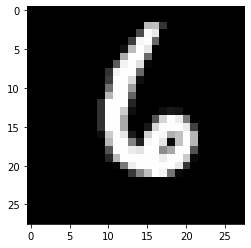

In [8]:
num = int(random.uniform(0,train_samples-trainLow_samples))
plt.imshow(data_high_train[num], cmap="gray") 
print(label_high_train[num])
plt.savefig(IMAGES_PATH + 'immagine.png')
plt.savefig(IMAGES_PATH + 'immagine.jpg')
plt.show() # Plot the image

In [9]:
print(data_low_train.shape)

(36017, 28, 28, 1)


In [10]:
OL_data_size = 200

tmp_data_trainOL = np.zeros((OL_data_size,28,28,1))
tmp_label_trainOL = np.zeros(OL_data_size)

for i in range(0, OL_data_size):
    
    n = int(random.uniform(0,testLow_samples))

    if(i<120):
        tmp_data_trainOL[i,:,:]  = data_low_train[n,:,:]
        tmp_label_trainOL[i]     = label_low_train[n]
    else:
        tmp_data_trainOL[i,:,:]  = data_high_train[n,:,:]
        tmp_label_trainOL[i]     = label_high_train[n]
        
        
# Shuffle the array
random.seed(8524)
order_list = list(range(0,len(tmp_label_trainOL)))    # create list of increasing numbers
random.shuffle(order_list)                        # shuffle the list of ordered numbers

data_trainOL  = np.zeros(tmp_data_trainOL.shape)
label_trainOL = np.empty(tmp_data_trainOL.shape[0], dtype=str) 

for i in range(0, data_trainOL.shape[0]):
    data_trainOL[i,:,:] = tmp_data_trainOL[order_list[i],:,:]    
    label_trainOL[i]  = tmp_label_trainOL[order_list[i]]


  Currently at 99.5% of saving

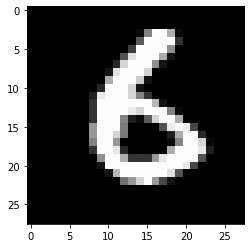

In [11]:
label_array = []

for i in range(0, OL_data_size):
    if(i<10):
        name = '00' + str(i)
    elif(i<100):
        name = '0' + str(i)
    else:
        name = str(i)
        
    plt.imshow(data_trainOL[i], cmap="gray") 
    plt.savefig(IMAGES_PATH + name + '.png', dpi=100)
    label_array.append(label_trainOL[i])
    
    print(f"\r  Currently at {np.round(np.round(i/OL_data_size,4)*100,2)}% of saving", end="")
    
    
with open(IMAGES_PATH+ 'label_order.txt', 'w') as f:
    
    for i in range(0, len(label_array)):
        f.write(str(label_array[i]))
        if(i!=len(label_array)-1):
            f.write(',')